In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd

from scipy.special import beta as beta_f
from scipy.stats import beta, gamma, binom, norm
from scipy.misc import factorial

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['text.usetex'] = True

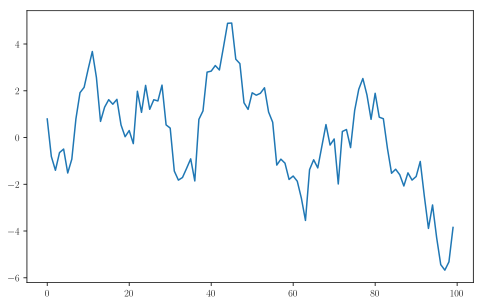

In [7]:
plt.plot(np.random.standard_normal(100).cumsum())
plt.show()